# Course project - Machine Learning for Big Data
***
In the following, we deal with an efficient and scalable approach to tackle the well-known problem of **finding all the connected components in a given graph**. Solving this problem can then transfer easily to application areas such as social network analysis, data mining, image processing, record linkage, etc. 


This project is based on the article [CCF: Fast and Scalable Connected Component Computation in MapReduce](https://www.cse.unr.edu/~hkardes/pdfs/ccf.pdf) written by H.Kardes, S.Agrawal, X.Wang and A.Sun in 2014.

We provide 2 versions of the code : one in Pyspark, one in Scala. We implemented both mostly for the sake of practicing to code in different languages. It also allows to compare relative wall clock time between Pyspark and Scala for CFF algorithm.

#### <font color=blue>  Students : Louis Monier & Théo Bodrito </font> 

In [1]:
import findspark
findspark.init()
import pyspark
import time 
import matplotlib.pyplot as plt

%matplotlib inline

Many different real world systems can be modeled as graphs (nodes/edges). As some graphs have a very large size, it has become an important topical issue to build highly scalable parallelized algorithms to efficiently extract useful information from them. The Map Reduce framework provides distributed computing which allows to process such enormous data volumes.

Let's recall the definition of a component : any two vertices that are connected to each other by paths. Finding connected component consists of finding the right connexion between those disjoint subgraphs (see figure below : 3 components ; source: [Wikipedia](https://en.wikipedia.org/wiki/Component_(graph_theory) ))
<img src="img/components.png" alt="Drawing" style="width: 200px;"/>

In [2]:
sc = pyspark.SparkContext(appName="Project")

# I - Data preparation 
*** 
The authors claim the viability of their approach on a massive graph of ~6B nodes and ~92 edges. In the present work, we used Databricks to test and review our implementations on toy graphs only since we did not have access to powerful cluster ressources. 


We chose to use the [Web Google graph](http://snap.stanford.edu/data/web-Google.html) released in 2002 by Google. There are 875K nodes and 5.1M edges in this graph. Nodes represent web pages and directed edges represent hyperlinks between them. 

Data is already clean. All we need to do is remove the headers and make sure nodes are converted to integers.
Basically, data contains 2 columns. Each row is a (key, value) couple that represents 2 connected nodes : [node1] --> [node2].

In [3]:
## Load the dataset
raw_data = sc.textFile("./web-Google.txt")
#graph = sc.parallelize([(1,2), (2, 3), (2, 4), (4, 5), (6, 7), (7, 8)])

In [4]:
## Data preparation
def clean_data(raw_data):
    data = raw_data.filter(lambda x : "#" not in x) # remove the header
    data =  data.map(lambda x : x.split("\t")).map(lambda x: (x[0], x[1])) # split data to form (key, value) 
    return data

In [5]:
# Main loop of the algorithm
def process(rdd, sorting=None):
    i = 0
    new_pairs = 1 # arbitrary >0
    while new_pairs > 0:
        print(f"iteration {i}")
        if sorting:
            rdd, new_pairs = CFF_iterate_sorting(rdd) 
        else:
            rdd, new_pairs = CFF_iterate(rdd) 
        print(f"# new pairs : {new_pairs}")
        i += 1
    return rdd

# II - Methods
<img src="img/method.png" alt="Drawing" style="width: 800px;"/>

Figure shows the **Connected Component Finder (CCF)** module. 

Inputs are a list of all the edges of the graph. We recall edges are modeled by a list of (key, value) representing [node1]-->[node2]. 

Outputs are the mapping from each node in the graph to the smallest node ID in its corresponding connected component (arbitrary choice made in the paper to identify the component).

In between, there is a loop over 2 Map Reduces jobs until all the nodes are assigned to a component ID : 
1. CCF-Iterate : link nodes to component ID
2. CFF-Dedup : dump copies of outputs of CFF-Iterate

There are 2 versions of CFF-Iterate. The second version is meant to improve the space complexity. Indeed, at some point, the algorithm needs to find the minimum value in a list. Instead of iterating through the entire list, values can be passed to the reducer in a sorted way with custom partitioning. the authors mention this improvement does not make such a difference when the graph of the graph is relatively small (<= 50k nodes). But this is more efficient when dealing with real world graphs with billions of nodes.

### A - Naïve CCF iterate
***

In [6]:
new_pairs = 0
def CFF_iterate(rdd):
    rdd_inv = rdd.map(lambda x: (x[1], x[0])) 
    graph = rdd.union(rdd_inv) # emit pairs
    graph = graph.groupByKey().mapValues(list).partitionBy(100).cache() # group by key and get values as a list
    graph = graph.map(lambda x: (int(x[0]), list(map(int, x[1])))) # Convert string to integer
    graph = graph.map(lambda x: (x[0], x[1], min(x[1]))) # extract min
    graph = graph.filter(lambda x: x[0] > x[2]) # filter out vid < amin
    graph = graph.map(lambda x: (x[0], [val for val in x[1] if val != x[2]], x[2])) # remove min from list
    
    new_pairs = graph.map(lambda x: len(x[1])).sum()  # get number of new pairs created

    emit_1 = graph.map(lambda x: (x[0], x[2]))
    emit_2 = graph.flatMap(lambda x: [(val, x[2]) for val in x[1]])
    emit_tot = emit_1.union(emit_2) # return all pairs (CFF-Dedup)
    
    new = emit_tot.map(lambda x: ((x[0], x[1]), [])) 
    new = new.groupByKey().mapValues(list)
    new = new.map(lambda x: (x[0][0], x[0][1]))
    return new, new_pairs

In [7]:
start_time = time.time()
graph = clean_data(raw_data)
output = process(graph)

n_components = output.map(lambda x : x[1]).distinct().count()
print(f"\n # components : {n_components}")

largest_component = output.groupBy(lambda x : x[1]).map(lambda x : len(x[1])).max() + 1
print(f"\n The largest component has {largest_component} elements")

time_ccf = time.time() - start_time
print("\n Total elasped time :", time_ccf, " s")

iteration 0
# new pairs : 8552232
iteration 1
# new pairs : 4758451
iteration 2
# new pairs : 3278772
iteration 3
# new pairs : 3888454
iteration 4
# new pairs : 1905323
iteration 5
# new pairs : 86783
iteration 6
# new pairs : 1318
iteration 7
# new pairs : 0

 # components : 2746

 The largest component has 855802 elements

 Total elasped time : 519.981143951416  s


### B - CCF iterate with secondary sorting
***

In [8]:
new_pairs = 0
def CFF_iterate_sorting(rdd):
    rdd_inv = rdd.map(lambda x: (x[1], x[0])) 
    graph = rdd.union(rdd_inv) # emit pairs
    graph = graph.groupByKey().mapValues(list).partitionBy(100).cache() # group by key and get values as a list
    graph = graph.map(lambda x: (int(x[0]), sorted(list(map(int, x[1]))))) # Convert string to integer
    graph = graph.map(lambda x: (x[0], x[1], x[1][0])) # extract min
    graph = graph.filter(lambda x: x[0] > x[2]) # filter out vid < amin
    graph = graph.map(lambda x: (x[0], x[1][1:], x[2])) # remove min from list

    new_pairs = graph.map(lambda x: len(x[1])).sum()  # get number of new pairs created

    emit_1 = graph.map(lambda x: (x[0], x[2]))
    emit_2 = graph.flatMap(lambda x: [(val, x[2]) for val in x[1]])
    emit_tot = emit_1.union(emit_2) # return all pairs 

    new = emit_tot.map(lambda x: ((x[0], x[1]), [])) # CFF-Dedup
    new = new.groupByKey().mapValues(list)
    new = new.map(lambda x: (x[0][0], x[0][1]))
    return new, new_pairs

In [9]:
start_time = time.time()
graph = clean_data(raw_data)
output = process(graph, sorting=True)

n_components = output.map(lambda x : x[1]).distinct().count()
print(f"\n # components : {n_components}")

largest_component = output.groupBy(lambda x : x[1]).map(lambda x : len(x[1])).max()
print(f"\n The largest component has {largest_component} elements")

time_ccf_sorting = time.time() - start_time
print("\n Total elasped time :", time_ccf_sorting, " s")

iteration 0
# new pairs : 8670951
iteration 1
# new pairs : 4821525
iteration 2
# new pairs : 3278772
iteration 3
# new pairs : 3888454
iteration 4
# new pairs : 1905323
iteration 5
# new pairs : 86783
iteration 6
# new pairs : 1318
iteration 7
# new pairs : 0

 # components : 2746

 The largest component has 855801 elements

 Total elasped time : 338.81761407852173  s


As explained by the authors, the "secondary sorting" improvement is only relevant with relatively large graphs (with millions of nodes). In this project, we use the web Google graph which is too small to see any wall clock time improvement.

###  Result : Connected component size distribution
***

In [10]:
cc = output.map(lambda x: (x[1], x[0])).groupByKey().mapValues(list)
cc = cc.map(lambda x: (len(x[1]), 1)) # key = CC size
cc = cc.reduceByKey(lambda x,y: x+y) # value = CC count
X = cc.map(lambda x: x[0]).collect()
Y = cc.map(lambda x: x[1]).collect()

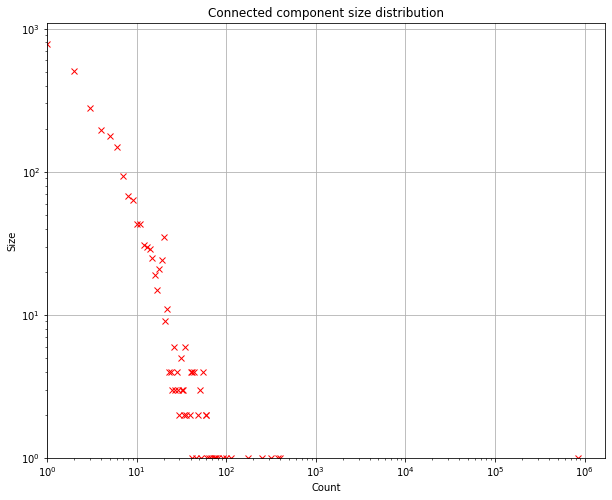

In [11]:
plt.figure(figsize=(10,8))
plt.plot(X, Y, 'rx')

plt.xscale("log")
plt.xlabel("Count")
plt.xlim(left=1)  

plt.yscale("log")
plt.ylabel("Size")
plt.ylim(bottom=1)  

plt.title('Connected component size distribution')
plt.grid(True)

###  Conclusions
***
Applying CCF-Iterate to the Web Google toy graph effiently finds all the connected components in the graph. The algorithm is simple to implement, yet allows to fully take advantage of the Map Reduce framework. With access to hadoop cluster, real world graphs with billions of nodes can be processed. In this project, we implemented the 2 versions of the algorithm and showed it can tackle a toy graph with limited computational resources. 